In [16]:
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_DockQ.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

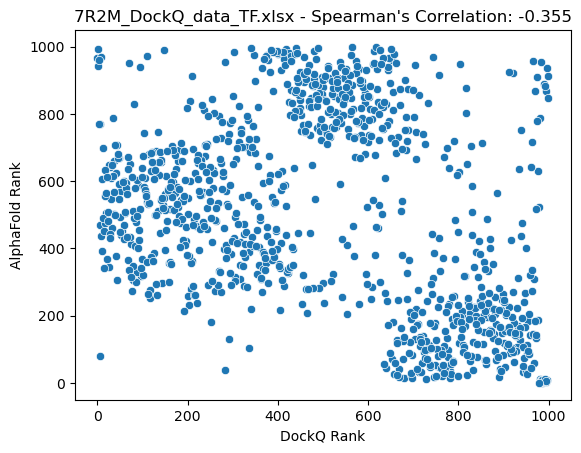

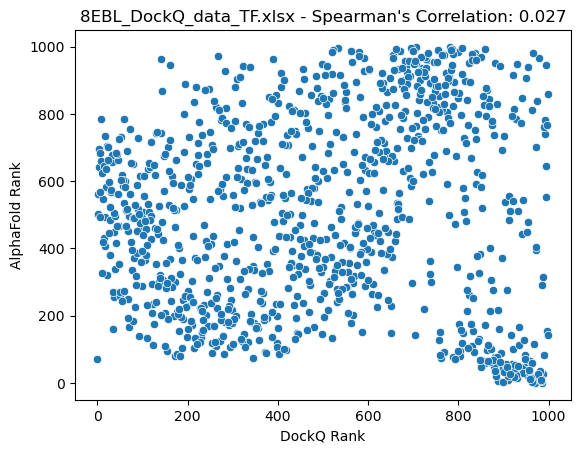

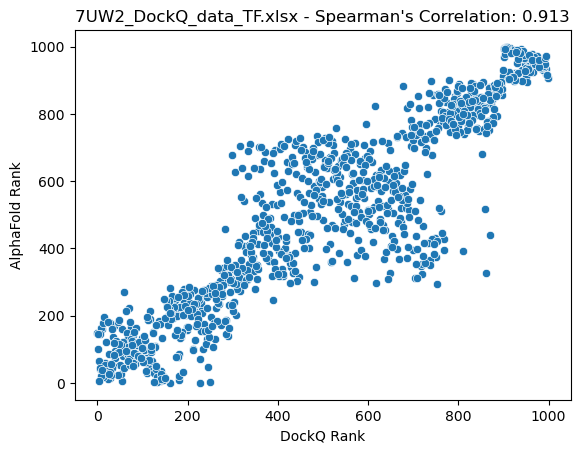

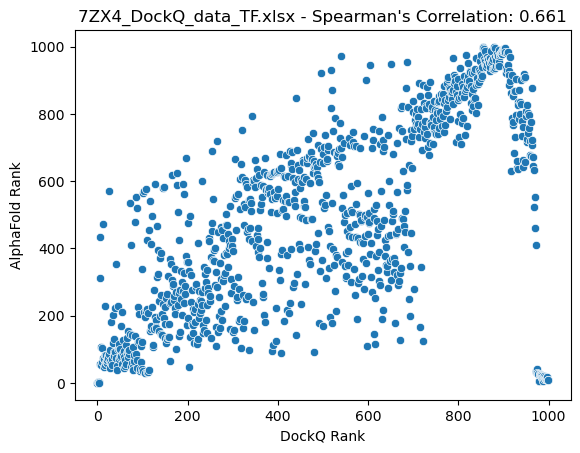

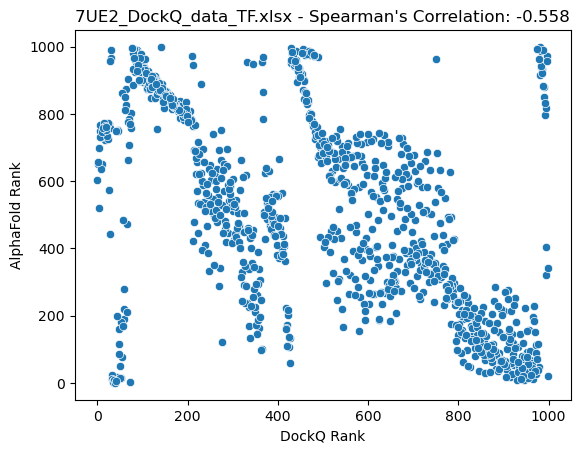

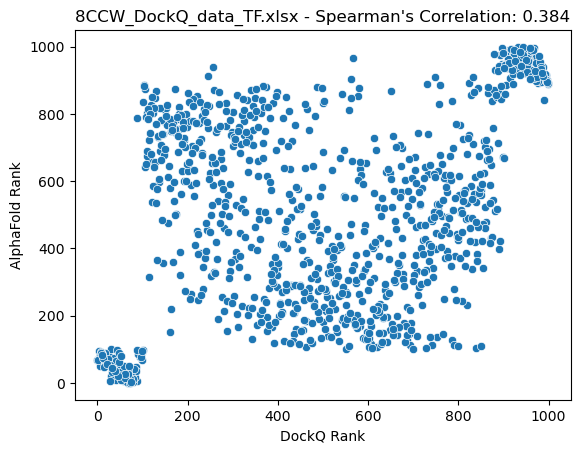

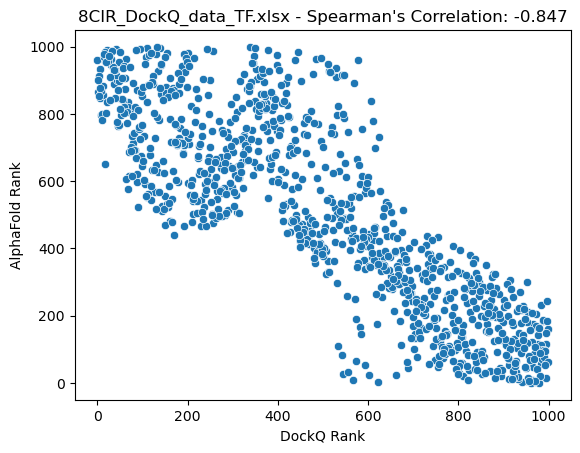

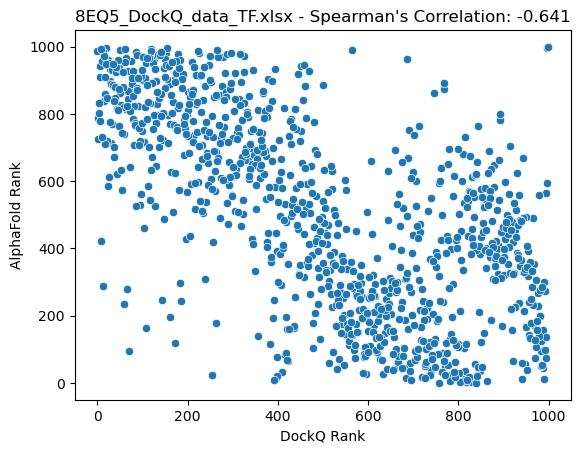

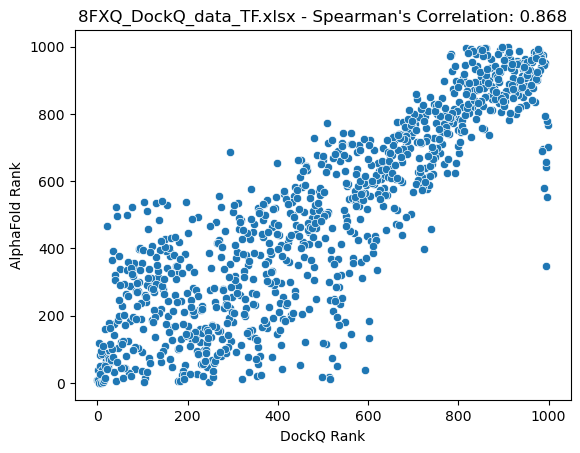

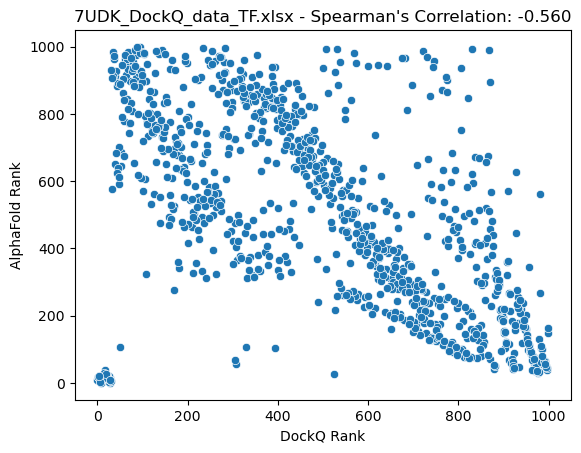

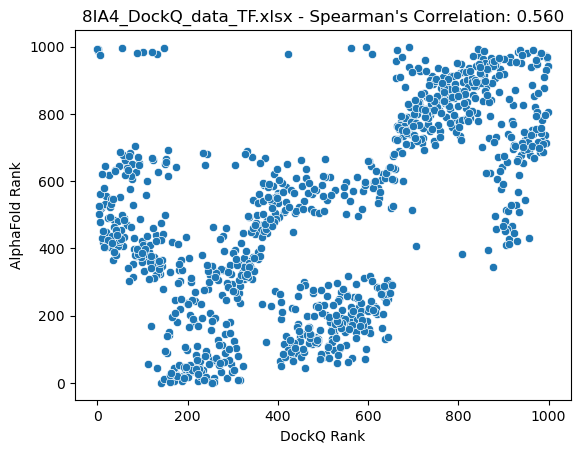

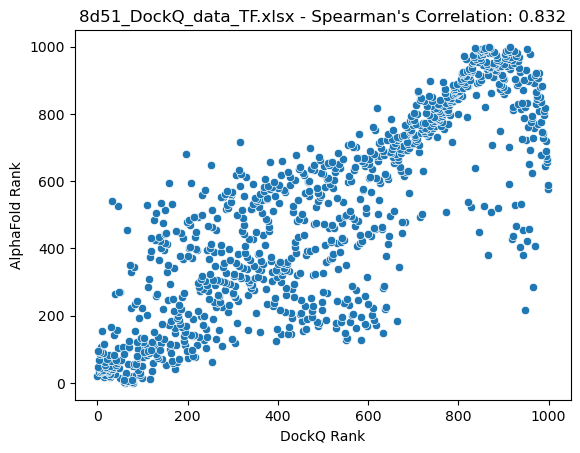

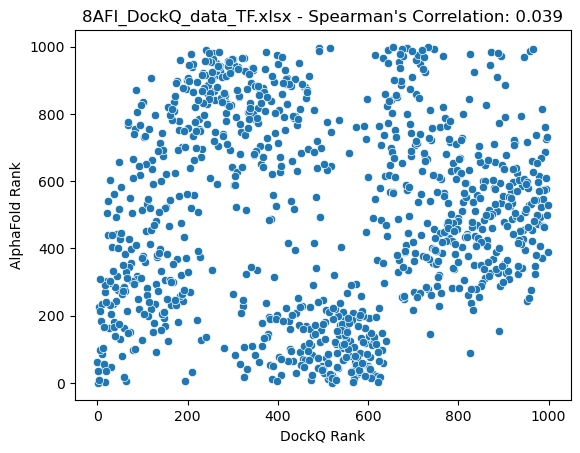

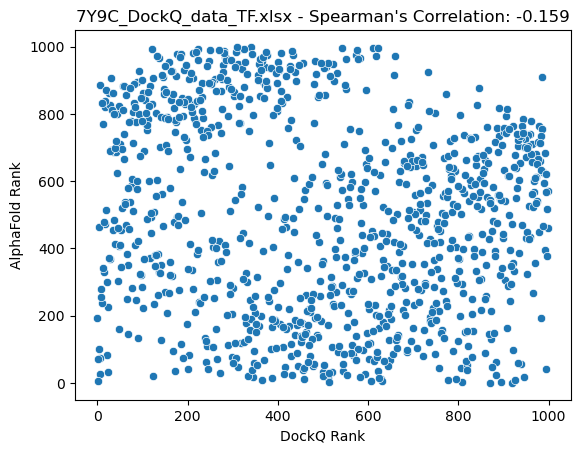

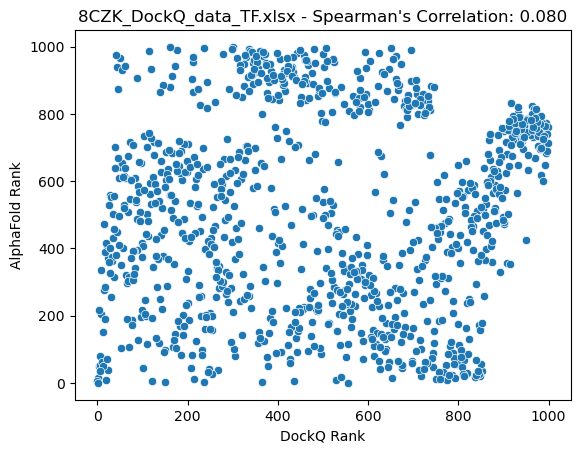

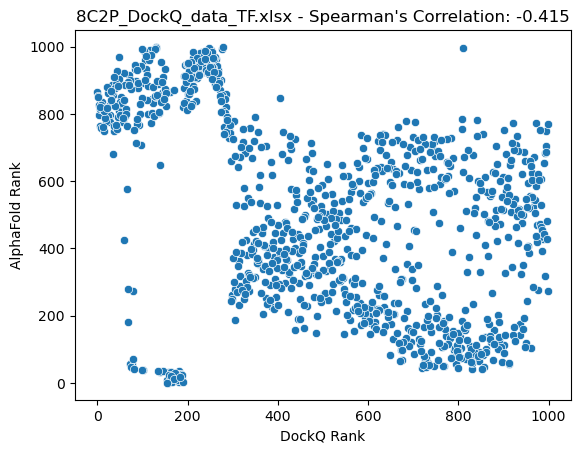

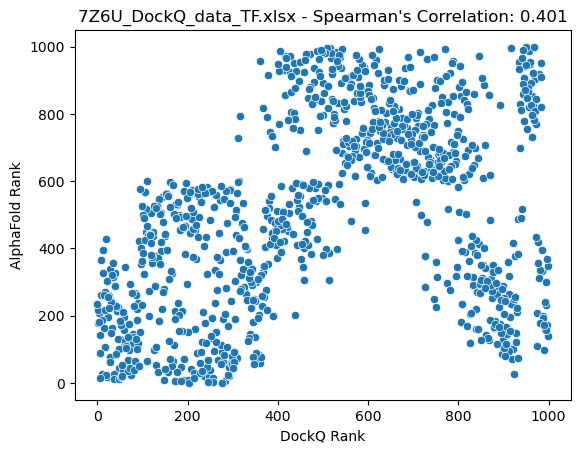

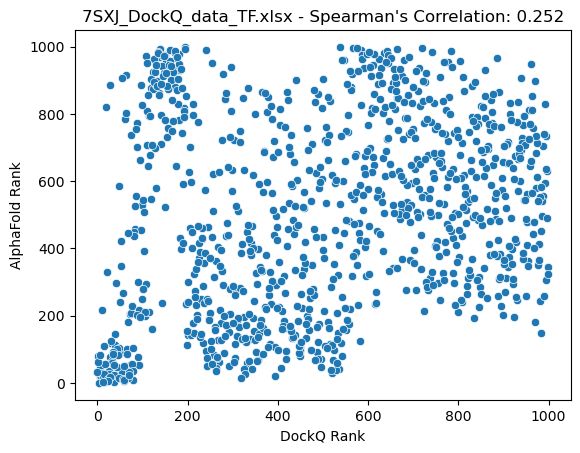

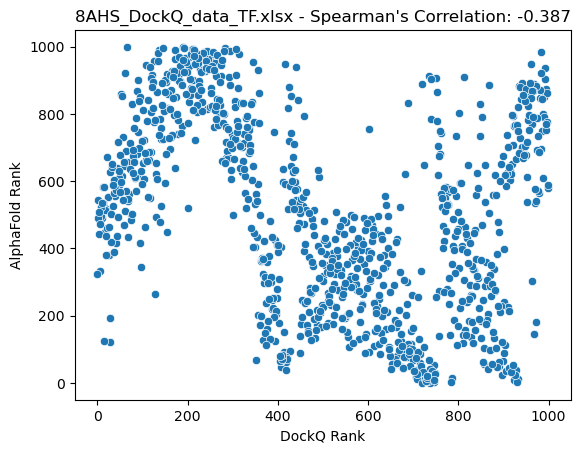

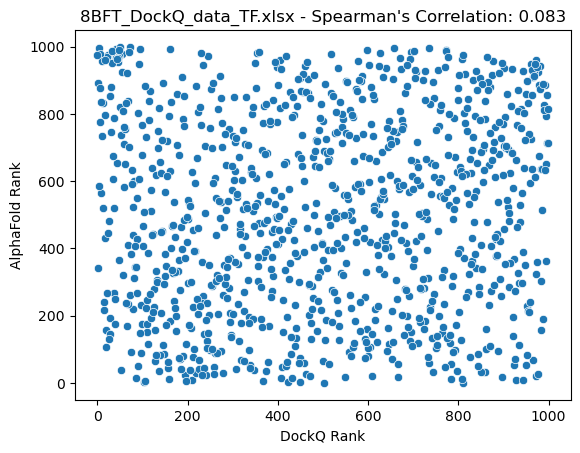

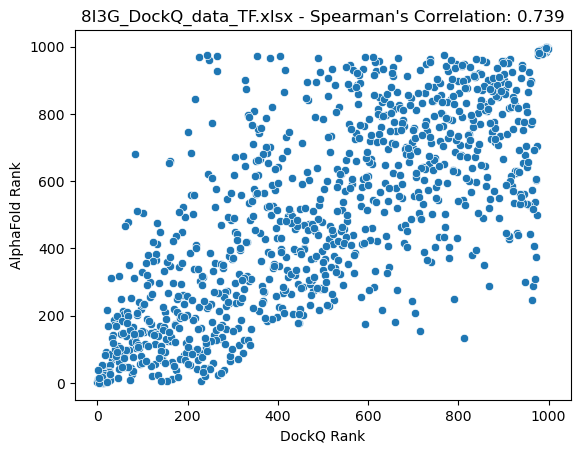

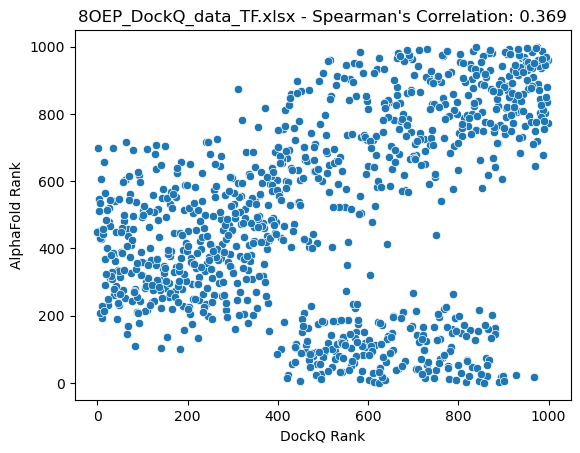

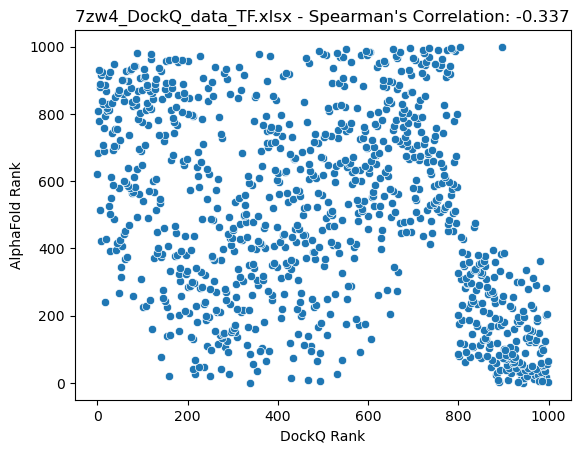

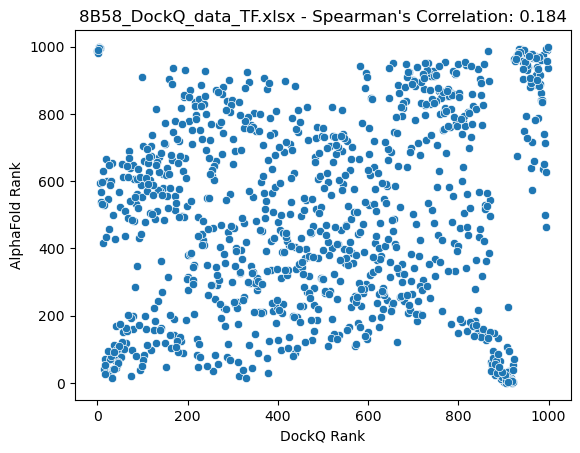

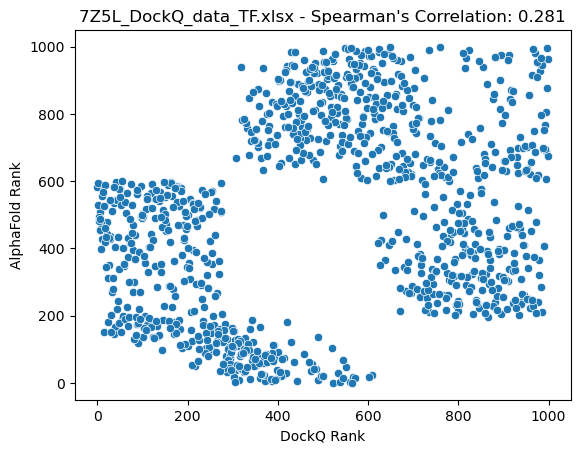

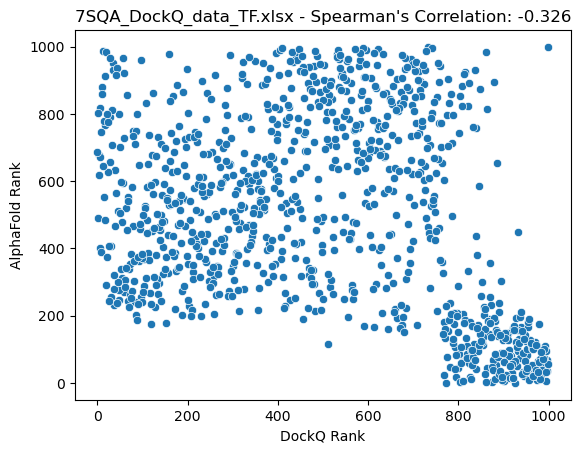

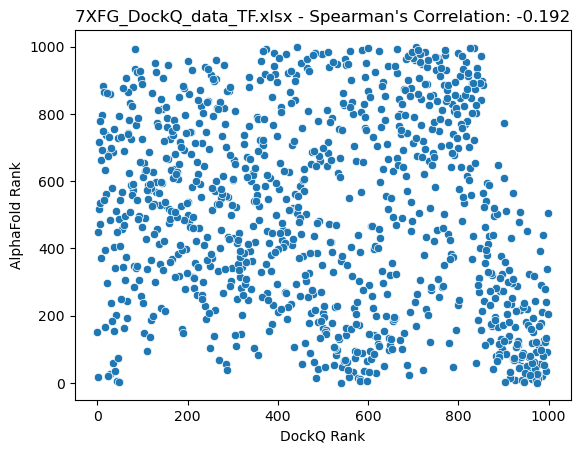

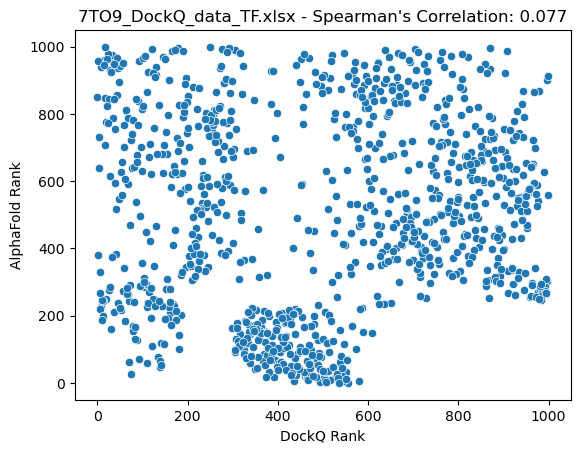

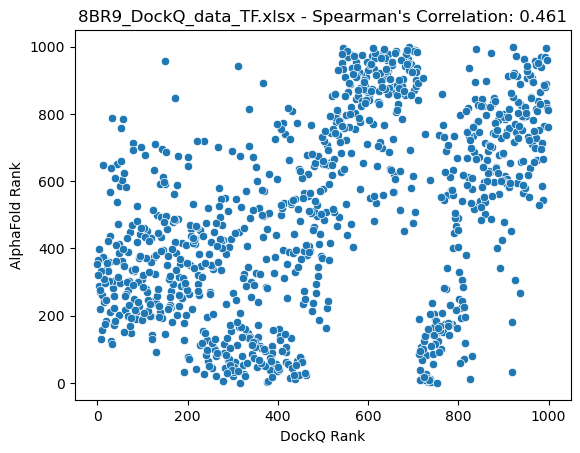

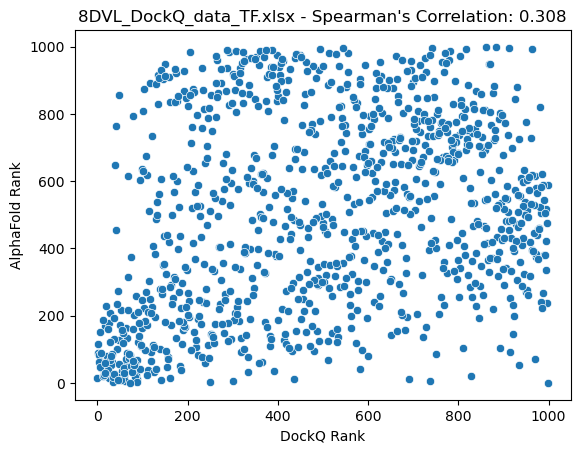

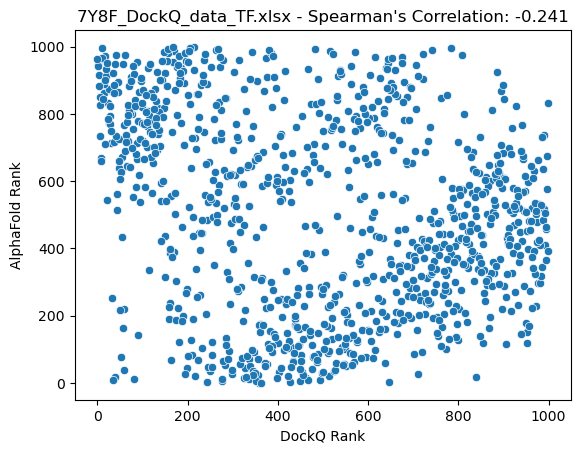

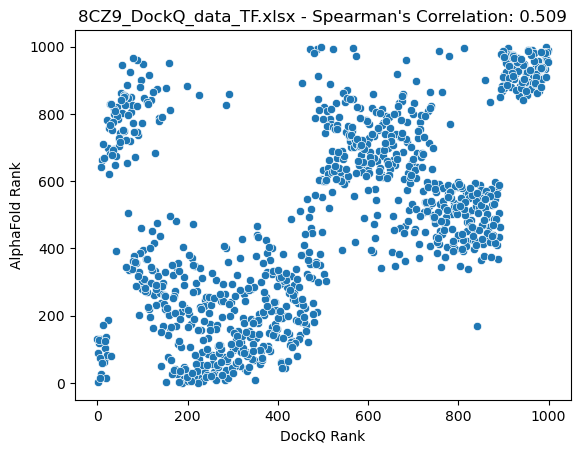

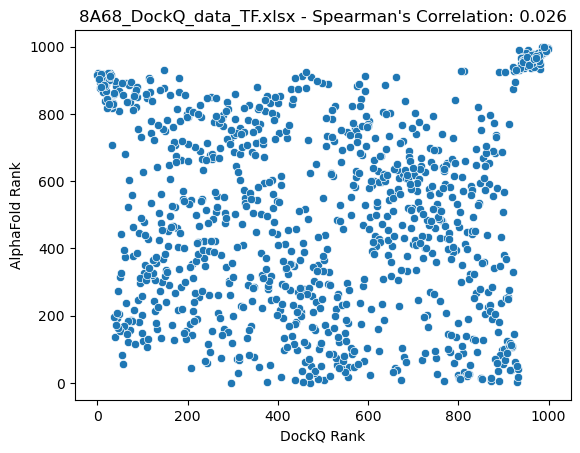

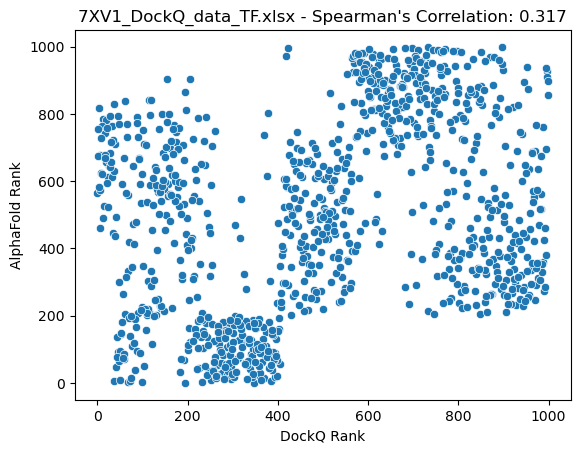

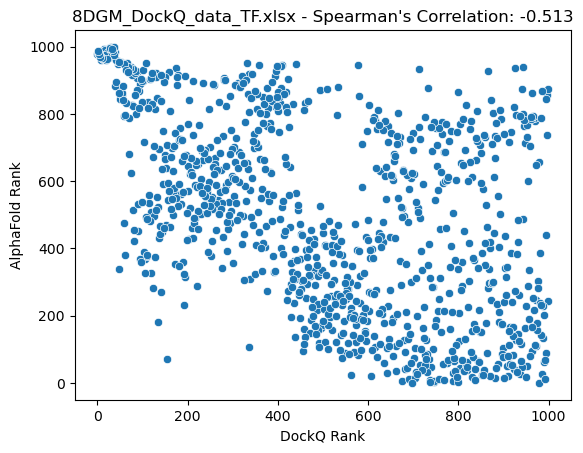

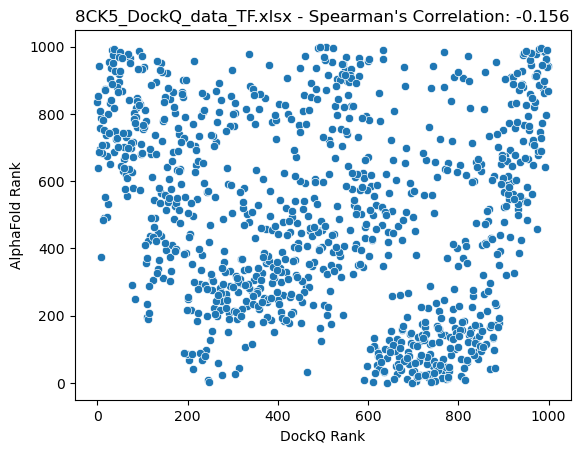

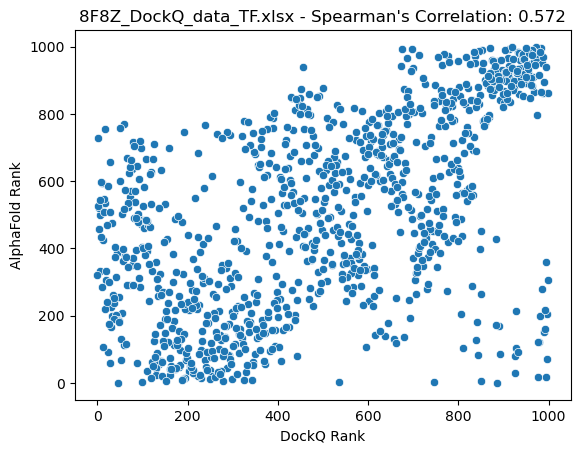

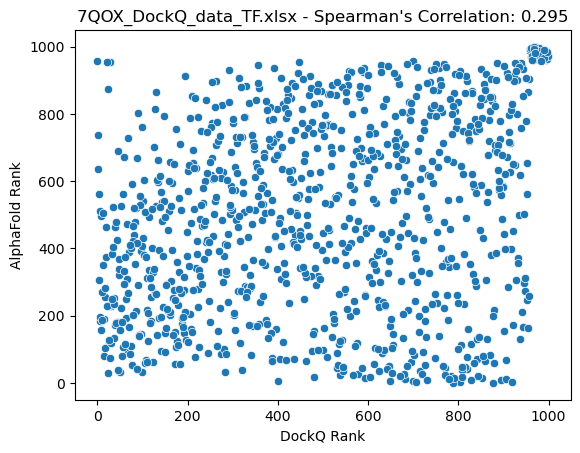

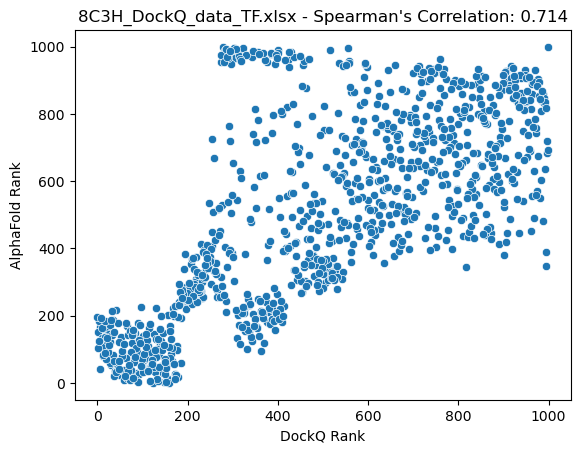

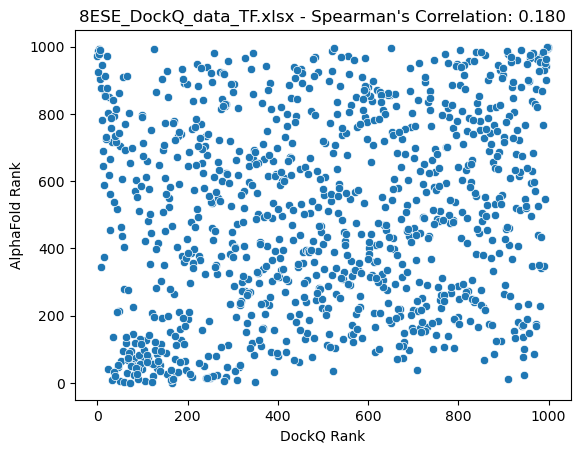

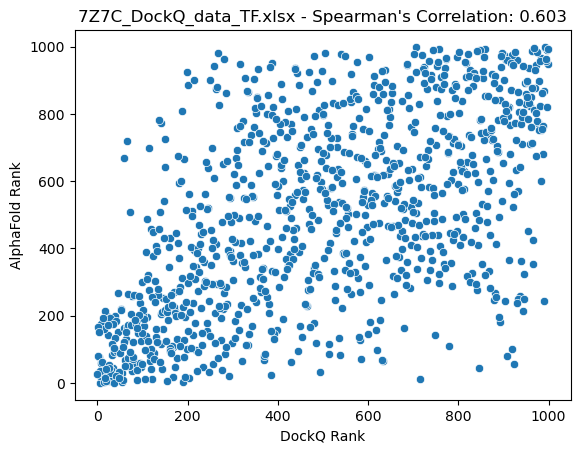

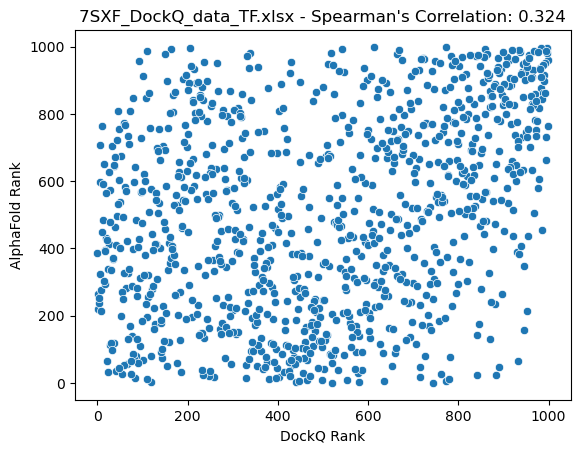

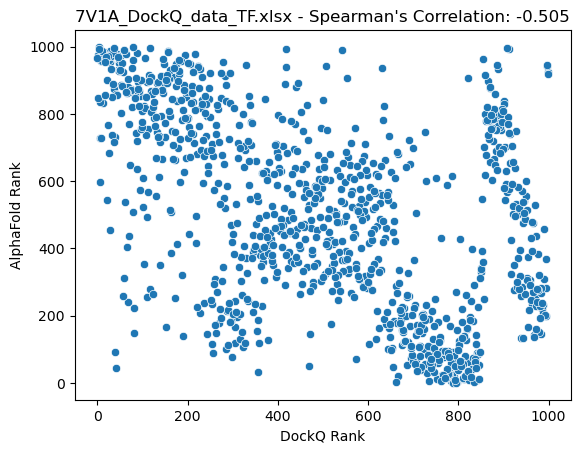

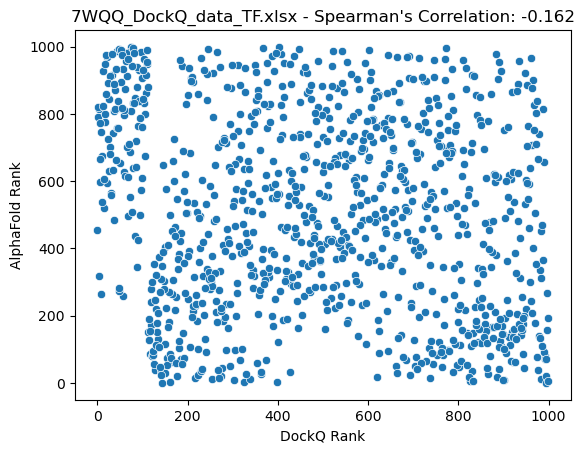

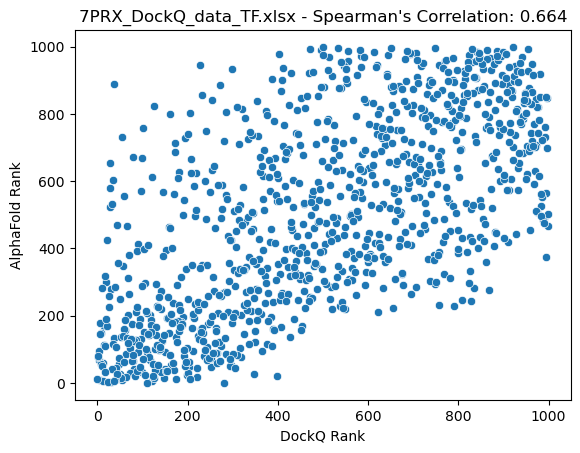

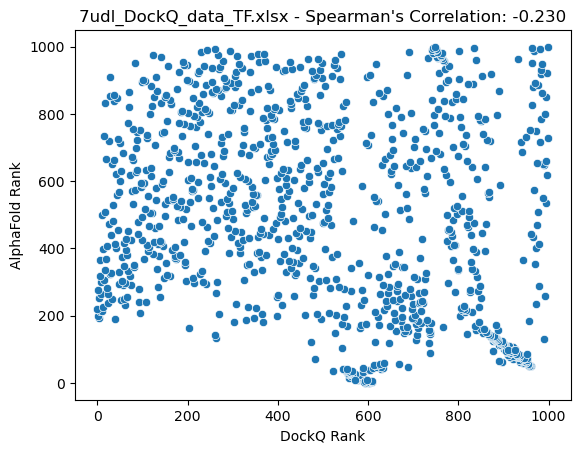

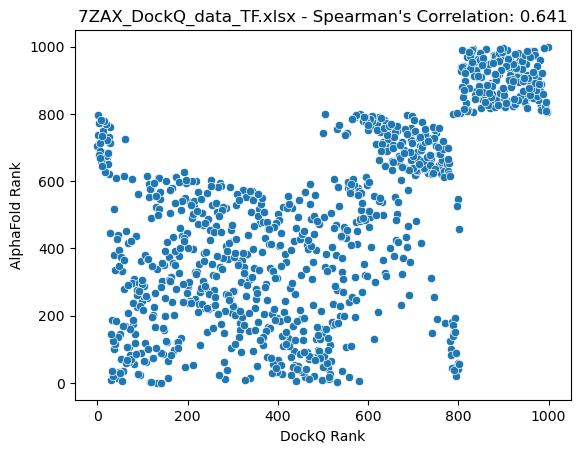

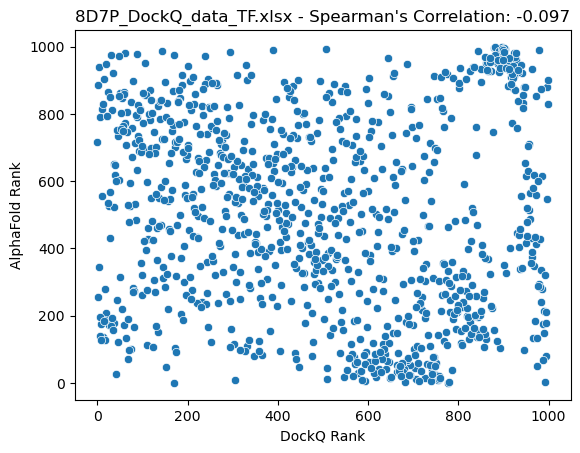

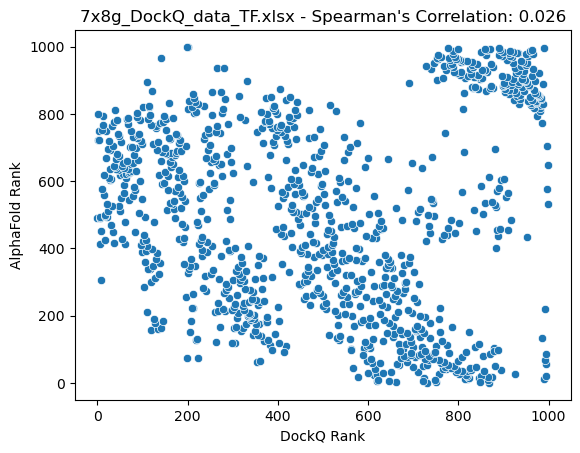

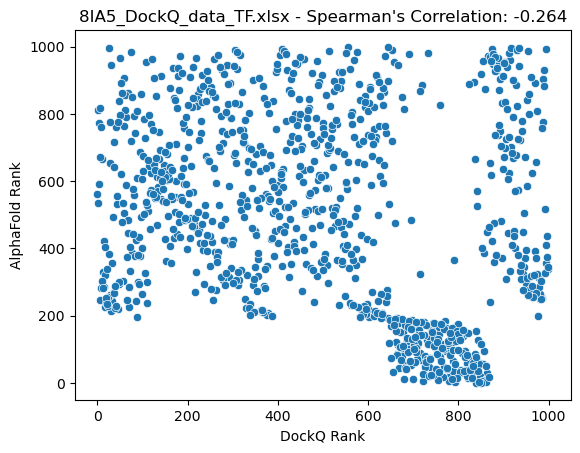

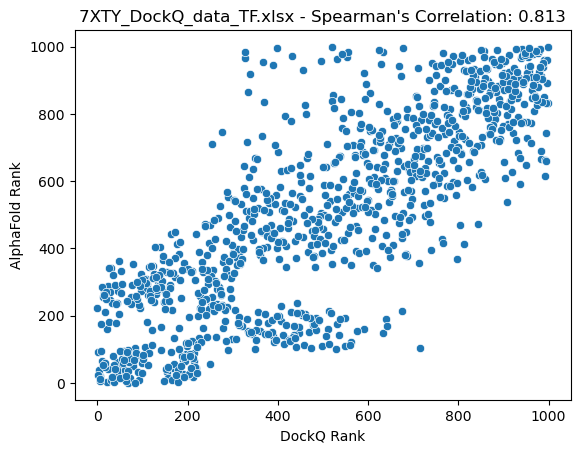

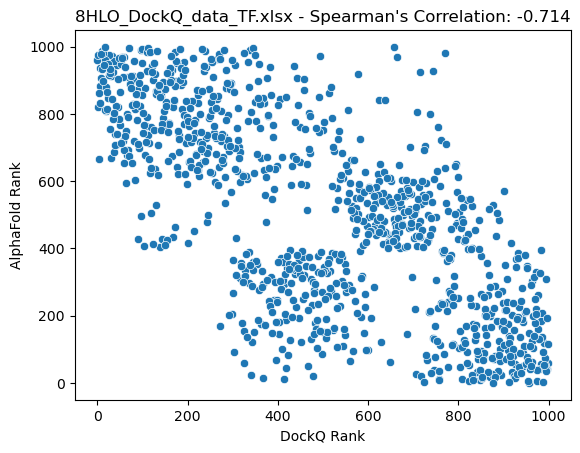

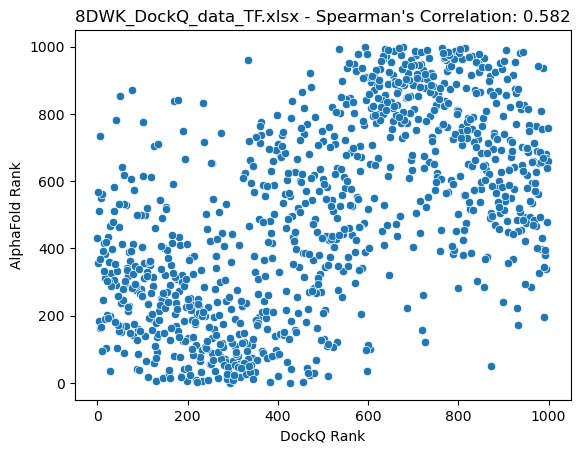

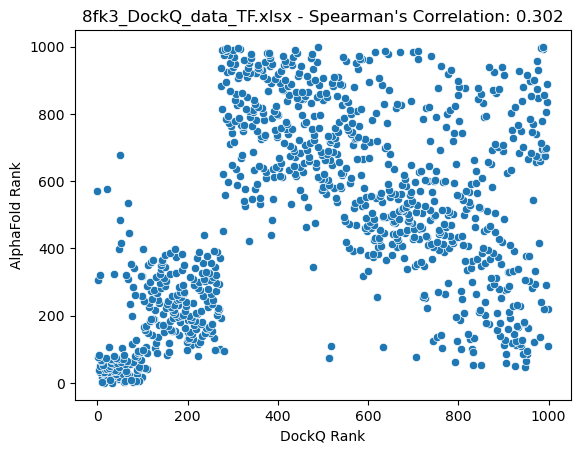

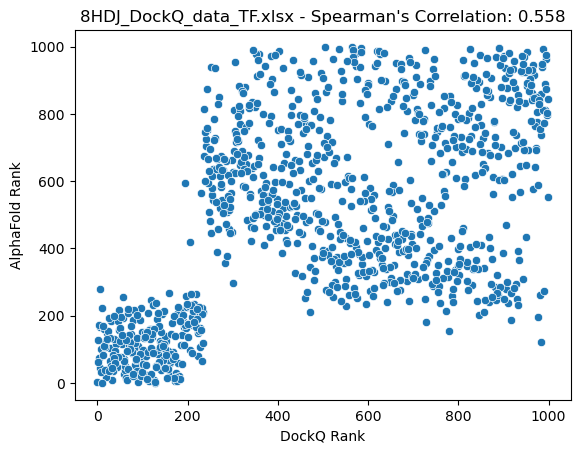

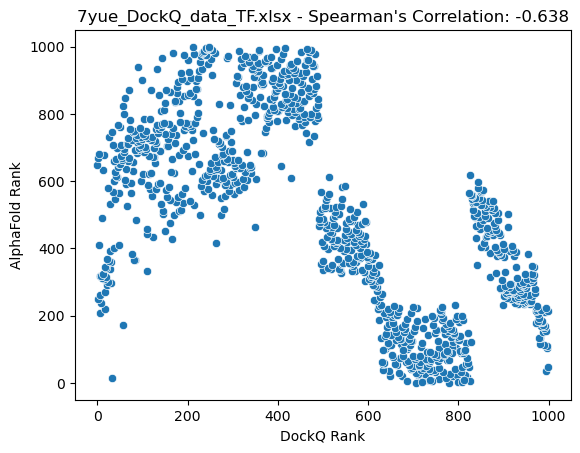

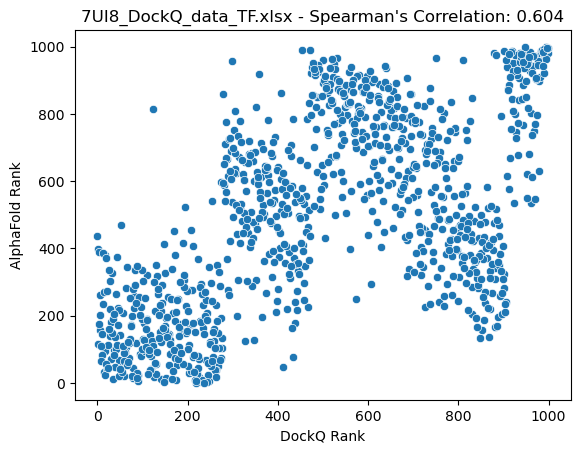

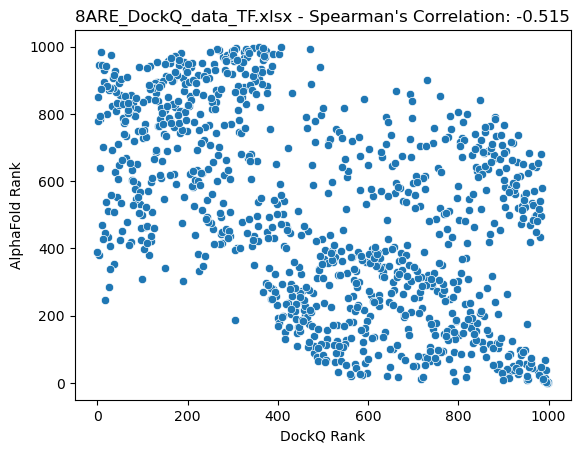

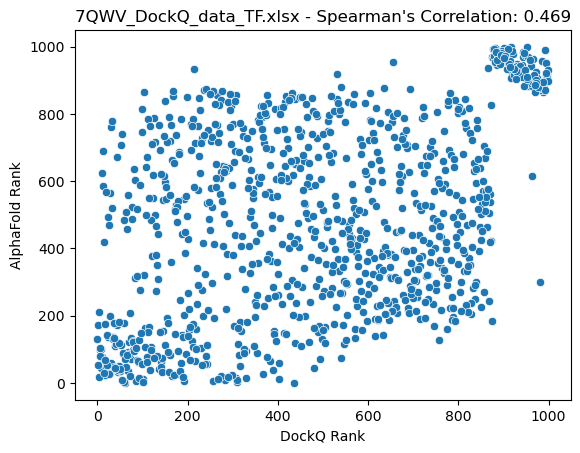

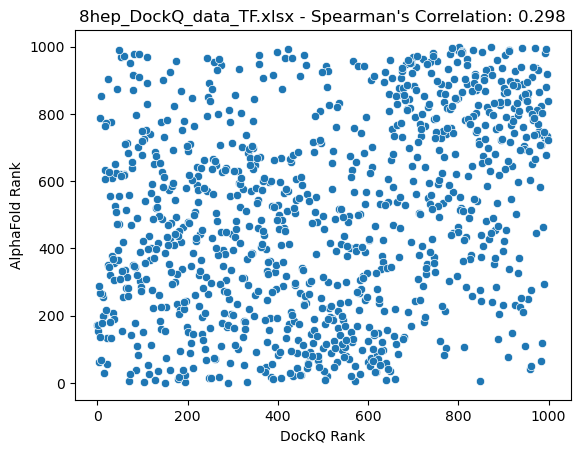

Process completed. Spearman correlation results saved to '/Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Spearman_Correlation/TF_Spearman/spearman_correlation_AF_TF.xlsx'.


In [3]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_DockQ.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

# Directory where your Excel files are stored
input_directory = config['AlphaFold_directory']
output_directory = config['Spearman_Correlation_directory_TF']  # Specify the output directory here

# Initialize a list to store the results
results = []

# Loop through each Excel file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith('.xlsx') and not filename.startswith('~$'):  # Skip temporary files
        file_path = os.path.join(input_directory, filename)
        try:
            # Load the data
            data = pd.read_excel(file_path)
            # Calculate Spearman's rank correlation
            spearman_corr, _ = spearmanr(data['AlphaFold Rank'], data['DockQ Rank'])
            # Append the results
            results.append((filename, spearman_corr))
            # Plotting
            sns.scatterplot(x='DockQ Rank', y='AlphaFold Rank', data=data)
            plt.title(f"{filename} - Spearman's Correlation: {spearman_corr:.3f}")
            plt.xlabel('DockQ Rank')
            plt.ylabel('AlphaFold Rank')
            plt.show()
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Save the Spearman's correlation coefficients to a new Excel file
output_file_path = os.path.join(output_directory, "spearman_correlation_AF_TF.xlsx")
results_df = pd.DataFrame(results, columns=['File Name', 'Spearman Correlation'])
results_df.to_excel(output_file_path, index=False)

print(f"Process completed. Spearman correlation results saved to '{output_file_path}'.")


In [4]:
import pandas as pd

# Load the Excel file
# Make sure to include the file extension, such as '.xlsx', in the file path
file_path = f"{config['Spearman_Correlation_directory_TF']}/spearman_correlation_AF_TF.xlsx" # Adjusted file path with extension
try:
    df = pd.read_excel(file_path)

    # Calculate the percentages of positive and negative Spearman correlation values
    positive_percentage = (df['Spearman Correlation'] > 0).mean() * 100
    negative_percentage = (df['Spearman Correlation'] < 0).mean() * 100
    
    # Calculate the average of Spearman Correlation values
    average_correlation = df['Spearman Correlation'].mean()

    # Print the results
    print(f"Percentage of positive correlations: {positive_percentage:.2f}%")
    print(f"Percentage of negative correlations: {negative_percentage:.2f}%")
    print(f"Average Spearman Correlation: {average_correlation:.2f}")
except FileNotFoundError:
    print(f"File not found. Please check the file path: {file_path}")


Percentage of positive correlations: 63.33%
Percentage of negative correlations: 36.67%
Average Spearman Correlation: 0.12


In [5]:
import os
import pandas as pd


def process_excel_files(input_directory, output_directory):
    # Define the output DataFrame
    output_df = pd.DataFrame(columns=['File Name', 'DockQ', 'Alphafold ranked', 'Loss'])

    # Iterate over each file in the input directory
    for file in os.listdir(input_directory):
        # Skip temporary or hidden files
        if file.endswith(".xlsx") and not file.startswith("~$"):
            # Extract the pdb_id from the file name
            pdb_id = file.split('_')[0]
            
            # Load the Excel file with error handling
            file_path = os.path.join(input_directory, file)
            try:
                data = pd.read_excel(file_path, engine='openpyxl')
            except Exception as e:
                print(f"Error reading {file}: {e}")
                continue

            # Find the highest DockQ score
            highest_dockq_score = data['DockQ'].max()

            # Find the DockQ score for "ranked_0.pdb_clean"
            dockq_score_for_ranked_0 = data.loc[data['File Name'] == 'ranked_0.pdb_clean', 'DockQ'].values[0] if not data.loc[data['File Name'] == 'ranked_0.pdb_clean', 'DockQ'].empty else None

            # Calculate the Loss
            Loss = highest_dockq_score - dockq_score_for_ranked_0 if dockq_score_for_ranked_0 is not None else None

            # Append the results to the output DataFrame using pd.concat
            new_row = pd.DataFrame({'File Name': [pdb_id], 'DockQ': [highest_dockq_score], 'Alphafold ranked': [dockq_score_for_ranked_0], 'Loss': [Loss]})
            output_df = pd.concat([output_df, new_row], ignore_index=True)

    # Save the output DataFrame to an Excel file in the output directory
    output_file_path = os.path.join(output_directory, 'AlphaFold_TF.xlsx')
    output_df.to_excel(output_file_path, index=False)

# Example usage
input_directory = config["AlphaFold_directory"]
output_directory = config["DockQ_Loss_directory_TF"]
process_excel_files(input_directory, output_directory)


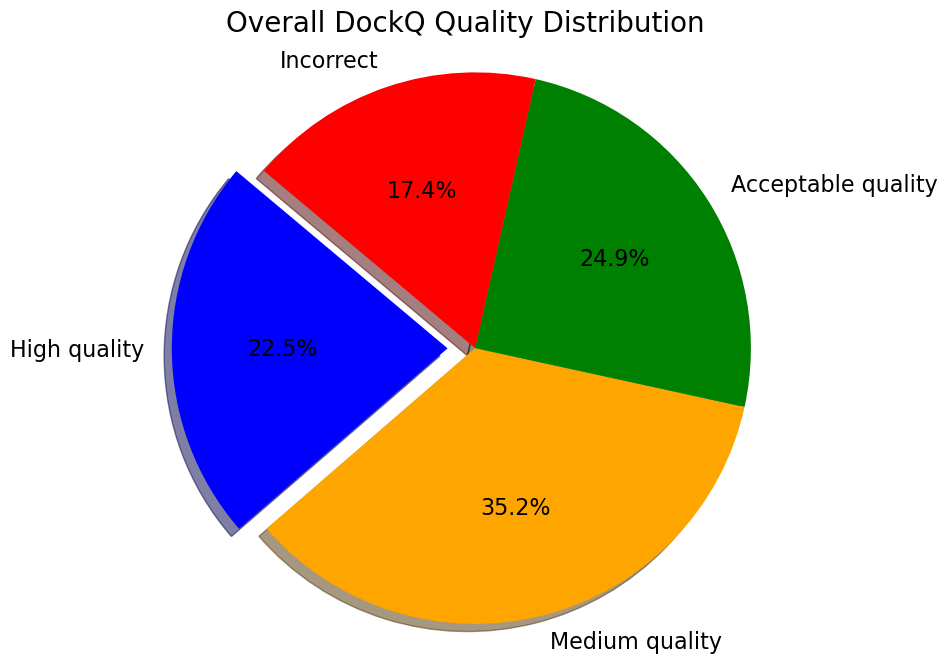

In [6]:
########################### All Models DockQ #############################

import os
import pandas as pd
import matplotlib.pyplot as plt

def categorize_quality(dockq_value):
    if dockq_value > 0.8:
        return 'High quality'
    elif 0.5 <= dockq_value <= 0.8:
        return 'Medium quality'
    elif 0.2 <= dockq_value < 0.5:
        return 'Acceptable quality'
    elif dockq_value < 0.2:
        return 'Incorrect'
    else:
        return 'Undefined'

directory_path = config['AlphaFold_directory']

quality_counts = {
    'High quality': 0,
    'Medium quality': 0,
    'Acceptable quality': 0,
    'Incorrect': 0
}

total_count = 0

for file_name in os.listdir(directory_path):
    if file_name.endswith('.xlsx') or file_name.endswith('.xls'):
        if file_name.startswith('~$'):
            continue

        file_path = os.path.join(directory_path, file_name)

        try:
            df = pd.read_excel(file_path)
            if df.empty:
                continue
        except Exception as e:
            continue

        if 'DockQ' not in df.columns:
            continue

        df['Quality Category'] = df['DockQ'].apply(categorize_quality)
        
        # Summarize counts for each category
        quality_counts_update = df['Quality Category'].value_counts()
        for quality, count in quality_counts_update.items():
            quality_counts[quality] += count
        total_count += len(df)

# Calculate overall percentages for each quality level
if total_count > 0:
    quality_percentages = {quality: (count / total_count) * 100 for quality, count in quality_counts.items()}
    
    # Data to plot
    labels = list(quality_percentages.keys())
    sizes = list(quality_percentages.values())
    # Update the colors as per your choice
    colors = ['blue', 'orange', 'green', 'red']
    explode = (0.1, 0, 0, 0)  # explode the first slice (High quality)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
            shadow=True, startangle=140, textprops={'fontsize': 16})
    plt.title('Overall DockQ Quality Distribution', fontsize=20)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
else:
    print("No data to plot.")


In [7]:

########################### FIRST RANKED DockQ #############################

import pandas as pd

def categorize_quality(dockq_value):
    if dockq_value > 0.8:
        return 'High quality'
    elif 0.5 <= dockq_value <= 0.8:
        return 'Medium quality'
    elif 0.2 <= dockq_value < 0.5:
        return 'Acceptable quality'
    elif dockq_value < 0.2:
        return 'Incorrect'
    else:
        return 'Undefined'

# Load the Excel file
file_path = f"{config['DockQ_Loss_directory_TF']}/AlphaFold_TF.xlsx"
data = pd.read_excel(file_path)

# Apply the categorization function to the DockQ column
data['AlphaFold-Quality Category'] = data['Alphafold ranked'].apply(categorize_quality)

# Calculate the percentage of each category
category_counts = data['AlphaFold-Quality Category'].value_counts(normalize=True) * 100

# Print the results
print(category_counts)



AlphaFold-Quality Category
High quality          33.333333
Medium quality        30.000000
Acceptable quality    20.000000
Incorrect             16.666667
Name: proportion, dtype: float64


ColabFold Analysis 

For Template_Based and Template_Free models, with analysis their First-Ranked predicted structures.

In [8]:
import os
import pandas as pd
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_DockQ.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

def process_excel_files(input_directory, output_directory):
    # Define the output DataFrame
    output_df = pd.DataFrame(columns=['File Name', 'DockQ', 'ColabFold ranked', 'Loss'])

    # Iterate over each file in the input directory
    for file in os.listdir(input_directory):
        if file.endswith(".xlsx") and not file.startswith('~$'):  # Skip temporary files
            # Extract the pdb_id from the file name
            pdb_id = file.split('_')[0]
            
            # Load the Excel file
            file_path = os.path.join(input_directory, file)
            try:
                data = pd.read_excel(file_path, engine='openpyxl')

                # Find the highest DockQ score
                highest_dockq_score = data['DockQ'].max()

                # Find the DockQ score for files ending with "_rank_1.pdb_clean"
                rank_1_row = data[data['File Name'].str.endswith("_rank_1.pdb_clean")]
                dockq_score_for_rank_1 = rank_1_row['DockQ'].values[0] if not rank_1_row.empty else None

                # Calculate the Loss
                Loss = highest_dockq_score - dockq_score_for_rank_1 if dockq_score_for_rank_1 is not None else None

                # Append the results to the output DataFrame
                output_df = pd.concat([output_df, pd.DataFrame([{
                    'File Name': pdb_id,
                    'DockQ': highest_dockq_score,
                    'ColabFold ranked': dockq_score_for_rank_1,
                    'Loss': Loss
                }])], ignore_index=True)

            except Exception as e:
                print(f"Error processing file {file}: {e}")

    # Save the output DataFrame to an Excel file in the output directory
    output_file_path = os.path.join(output_directory, 'ColabFold_TF.xlsx')
    output_df.to_excel(output_file_path, index=False, engine='openpyxl')
    print(f"All data extracted and written to {output_file_path}")

# Example usage
input_directory = config["ColabFold_directory"]  # Update the path as per your requirement
output_directory = config["DockQ_Loss_directory_TF"]  # Update the path as per your requirement

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

process_excel_files(input_directory, output_directory)


All data extracted and written to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Loss/TF_Loss/ColabFold_TF.xlsx


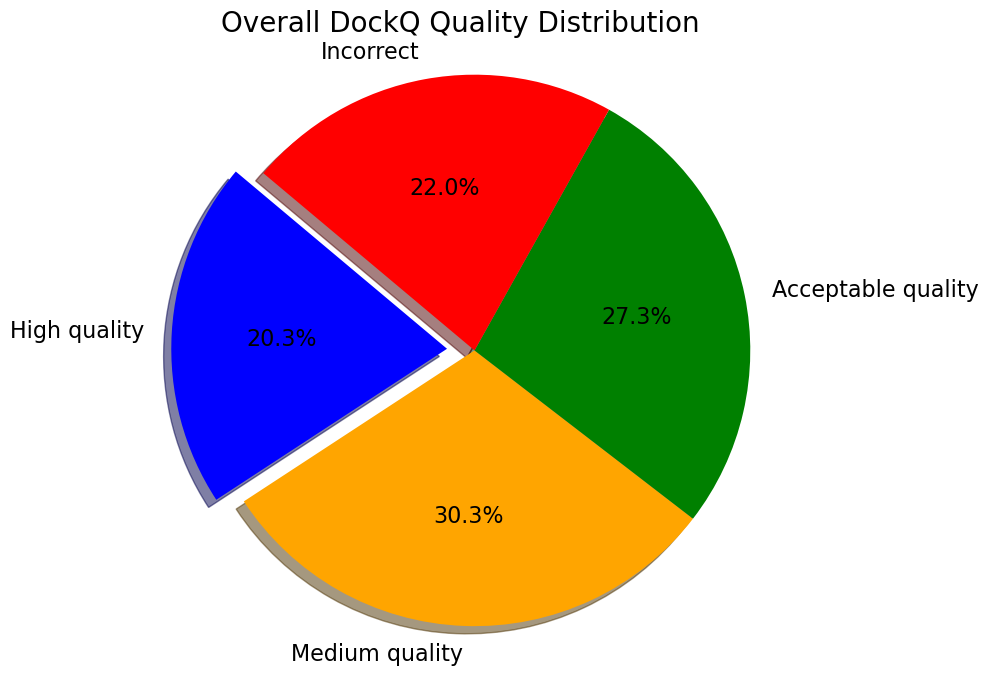

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def categorize_quality(dockq_value):
    if dockq_value > 0.8:
        return 'High quality'
    elif 0.5 <= dockq_value <= 0.8:
        return 'Medium quality'
    elif 0.2 <= dockq_value < 0.5:
        return 'Acceptable quality'
    elif dockq_value < 0.2:
        return 'Incorrect'
    else:
        return 'Undefined'

directory_path = config['ColabFold_directory']

quality_counts = {
    'High quality': 0,
    'Medium quality': 0,
    'Acceptable quality': 0,
    'Incorrect': 0
}

total_count = 0

for file_name in os.listdir(directory_path):
    if file_name.endswith('.xlsx') or file_name.endswith('.xls'):
        if file_name.startswith('~$'):
            continue

        file_path = os.path.join(directory_path, file_name)

        try:
            df = pd.read_excel(file_path)
            if df.empty:
                continue
        except Exception as e:
            continue

        if 'DockQ' not in df.columns:
            continue

        df['Quality Category'] = df['DockQ'].apply(categorize_quality)
        
        # Summarize counts for each category
        quality_counts_update = df['Quality Category'].value_counts()
        for quality, count in quality_counts_update.items():
            quality_counts[quality] += count
        total_count += len(df)

# Calculate overall percentages for each quality level
if total_count > 0:
    quality_percentages = {quality: (count / total_count) * 100 for quality, count in quality_counts.items()}
    
    # Data to plot
    labels = list(quality_percentages.keys())
    sizes = list(quality_percentages.values())
    # Update the colors as per your choice
    colors = ['blue', 'orange', 'green', 'red']
    explode = (0.1, 0, 0, 0)  # explode the first slice (High quality)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
            shadow=True, startangle=140, textprops={'fontsize': 16})
    plt.title('Overall DockQ Quality Distribution', fontsize=20)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
else:
    print("No data to plot.")


In [10]:
import pandas as pd

def categorize_quality(dockq_value):
    if dockq_value > 0.8:
        return 'High quality'
    elif 0.5 <= dockq_value <= 0.8:
        return 'Medium quality'
    elif 0.2 <= dockq_value < 0.5:
        return 'Acceptable quality'
    elif dockq_value < 0.2:
        return 'Incorrect'
    else:
        return 'Undefined'

# Load the Excel file
file_path = f"{config['DockQ_Loss_directory_TF']}/ColabFold_TF.xlsx"  # Update this to your file path
data = pd.read_excel(file_path)

# Apply the categorization function to the DockQ column
data['ColabFold-Quality Category'] = data['ColabFold ranked'].apply(categorize_quality)

# Calculate the percentage of each category
category_counts = data['ColabFold-Quality Category'].value_counts(normalize=True) * 100

# Print the results
print(category_counts)


ColabFold-Quality Category
Medium quality        33.333333
Acceptable quality    28.333333
High quality          21.666667
Incorrect             16.666667
Name: proportion, dtype: float64


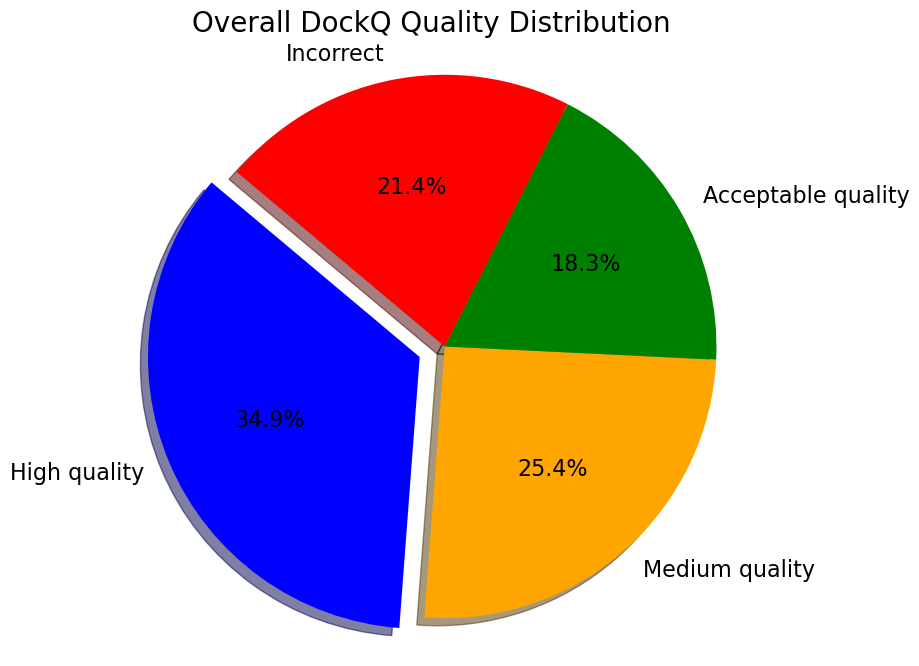

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def categorize_quality(dockq_value):
    if dockq_value > 0.8:
        return 'High quality'
    elif 0.5 <= dockq_value <= 0.8:
        return 'Medium quality'
    elif 0.2 <= dockq_value < 0.5:
        return 'Acceptable quality'
    elif dockq_value < 0.2:
        return 'Incorrect'
    else:
        return 'Undefined'

directory_path = config['AlphaFold3_directory']

quality_counts = {
    'High quality': 0,
    'Medium quality': 0,
    'Acceptable quality': 0,
    'Incorrect': 0
}

total_count = 0

for file_name in os.listdir(directory_path):
    if file_name.endswith('.xlsx') or file_name.endswith('.xls'):
        if file_name.startswith('~$'):
            continue

        file_path = os.path.join(directory_path, file_name)

        try:
            df = pd.read_excel(file_path)
            if df.empty:
                continue
        except Exception as e:
            continue

        if 'DockQ' not in df.columns:
            continue

        df['Quality Category'] = df['DockQ'].apply(categorize_quality)
        
        # Summarize counts for each category
        quality_counts_update = df['Quality Category'].value_counts()
        for quality, count in quality_counts_update.items():
            quality_counts[quality] += count
        total_count += len(df)

# Calculate overall percentages for each quality level
if total_count > 0:
    quality_percentages = {quality: (count / total_count) * 100 for quality, count in quality_counts.items()}
    
    # Data to plot
    labels = list(quality_percentages.keys())
    sizes = list(quality_percentages.values())
    # Update the colors as per your choice
    colors = ['blue', 'orange', 'green', 'red']
    explode = (0.1, 0, 0, 0)  # explode the first slice (High quality)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
            shadow=True, startangle=140, textprops={'fontsize': 16})
    plt.title('Overall DockQ Quality Distribution', fontsize=20)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
else:
    print("No data to plot.")


In [12]:
import os
import pandas as pd

def process_excel_files(input_directory, output_directory):
    # Define the output DataFrame
    output_df = pd.DataFrame(columns=['File Name', 'DockQ', 'AF3 ranked', 'Loss'])

    # Iterate over each file in the input directory
    for file in os.listdir(input_directory):
        if file.endswith(".xlsx"):
            file_path = os.path.join(input_directory, file)
            try:
                # Load the Excel file
                data = pd.read_excel(file_path, engine='openpyxl')

                # Find the highest DockQ score
                highest_dockq_score = data['DockQ'].max()

                # Find the DockQ score for files ending with "_model_0.pdb_clean"
                rank_1_row = data[data['File Name'].str.endswith("_model_0.pdb_clean")]
                dockq_score_for_rank_1 = rank_1_row['DockQ'].values[0] if not rank_1_row.empty else None

                # Calculate the Loss
                loss = highest_dockq_score - dockq_score_for_rank_1 if dockq_score_for_rank_1 is not None else None

                # Append the results to the output DataFrame using pd.concat
                new_row = pd.DataFrame([{
                    'File Name': file.split('_')[0],
                    'DockQ': highest_dockq_score,
                    'AF3 ranked': dockq_score_for_rank_1,
                    'Loss': loss
                }])
                output_df = pd.concat([output_df, new_row], ignore_index=True)

            except Exception as e:
                print(f"Failed to process {file}: {e}")

    # Save the output DataFrame to an Excel file in the output directory
    output_file_path = os.path.join(output_directory, 'AF3_Loss.xlsx')
    output_df.to_excel(output_file_path, index=False, engine='openpyxl')
    print(f"All data extracted and written to {output_file_path}")

# Update the paths as per your requirement
input_directory = config['AlphaFold3_directory']
output_directory = config['DockQ_Loss_directory_TB']
process_excel_files(input_directory, output_directory)


All data extracted and written to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Loss/TB_Loss/AF3_Loss.xlsx


In [13]:
import pandas as pd

def categorize_quality(dockq_value):
    if dockq_value > 0.8:
        return 'High quality'
    elif 0.5 <= dockq_value <= 0.8:
        return 'Medium quality'
    elif 0.2 <= dockq_value < 0.5:
        return 'Acceptable quality'
    elif dockq_value < 0.2:
        return 'Incorrect'
    else:
        return 'Undefined'

# Load the Excel file
file_path = f"{config['DockQ_Loss_directory_TB']}/AF3_Loss.xlsx"  # Update this to your file path
data = pd.read_excel(file_path)

# Apply the categorization function to the DockQ column
data['AlphaFold3-Quality Category'] = data['AF3 ranked'].apply(categorize_quality)

# Calculate the percentage of each category
category_counts = data['AlphaFold3-Quality Category'].value_counts(normalize=True) * 100

# Print the results
print(category_counts)



AlphaFold3-Quality Category
High quality          35.593220
Medium quality        25.423729
Incorrect             20.338983
Acceptable quality    18.644068
Name: proportion, dtype: float64


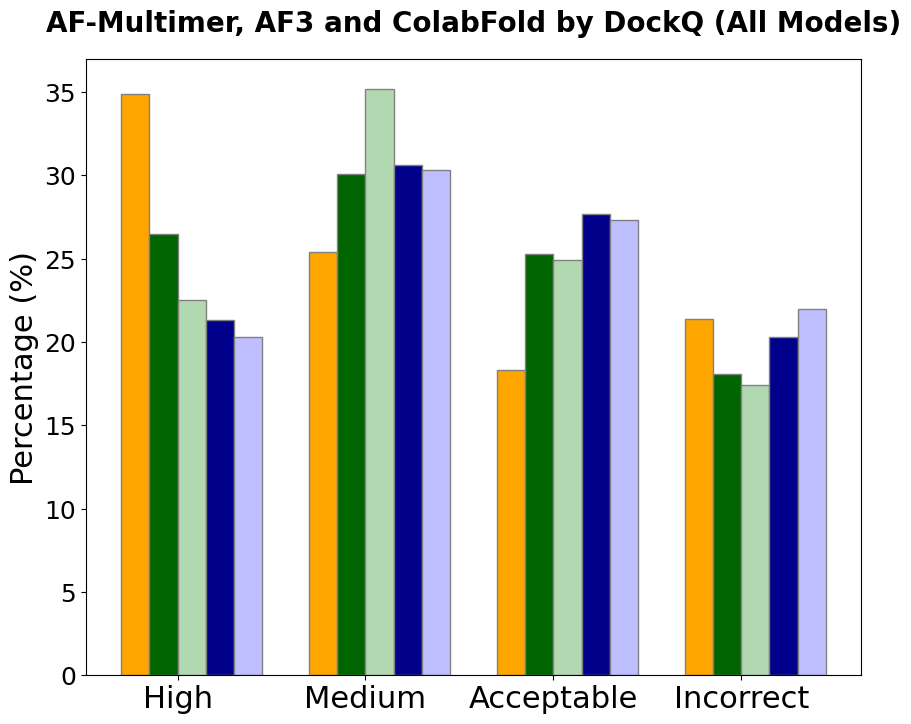

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import json


# Extract the directory path from the config
figures_directory = config["Main_Figures_directory"]

# Data for TB and TF of AlphaFold and ColabFold
categories = ['High', 'Medium', 'Acceptable', 'Incorrect']
# AlphaFold values
af3_values = [34.9, 25.4, 18.3, 21.4]
af_tb_values = [26.5, 30.1, 25.3, 18.1]
af_tf_values = [22.5, 35.2, 24.9, 17.4]
# ColabFold values
cf_tb_values = [21.3, 30.6, 27.7, 20.3]
cf_tf_values = [20.3, 30.3, 27.3, 22]

# Positions of the bar-groups
barWidth = 0.15  # Narrower bar width to fit all bars
r1 = np.arange(len(categories))  # Positions for the first set of bars
r2 = [x + barWidth for x in r1]  # Positions for the second set
r3 = [x + barWidth for x in r2]  # Positions for the third set
r4 = [x + barWidth for x in r3]  # Positions for the fourth set
r5 = [x + barWidth for x in r4]  # Positions for the fifth set

plt.figure(figsize=(10, 8))  # Slightly wider figure to accommodate more bars
plt.bar(r1, af3_values, color='orange', width=barWidth, edgecolor='grey', label='AlphaFold3')
plt.bar(r2, af_tb_values, color='#006400', width=barWidth, edgecolor='grey', label='AlphaFold Template_based')
plt.bar(r3, af_tf_values, color='#b2d8b2', width=barWidth, edgecolor='grey', label='AlphaFold Template_Free')  # Very light green
plt.bar(r4, cf_tb_values, color='darkblue', width=barWidth, edgecolor='grey', label='ColabFold Template_based')
plt.bar(r5, cf_tf_values, color='#bfbfff', width=barWidth, edgecolor='grey', label='ColabFold Template_Free')

# Add xticks on the middle of the group bars, adjust font sizes
plt.xticks([r + 1.5*barWidth for r in range(len(categories))], categories, rotation=0, fontsize=22)
# plt.xlabel('Quality Category', fontsize=20)  # Larger font size for x-axis label
plt.ylabel('Percentage (%)', fontsize=22)  # Larger font size for y-axis label

# Adjust y-axis font size
plt.tick_params(axis='y', labelsize=18)  # Adjusted y-axis font size

# Create legend & Show graphic with larger font
# plt.legend(fontsize=14)
plt.title('AF-Multimer, AF3 and ColabFold by DockQ (All Models)', fontsize=20, fontweight='bold', pad=20)  # Added pad parameter

# Construct the output path
output_filename = 'Fig_1a.png'
output_path = f"{figures_directory}/{output_filename}"

plt.savefig(output_path, format='png', dpi=1000)

plt.show()


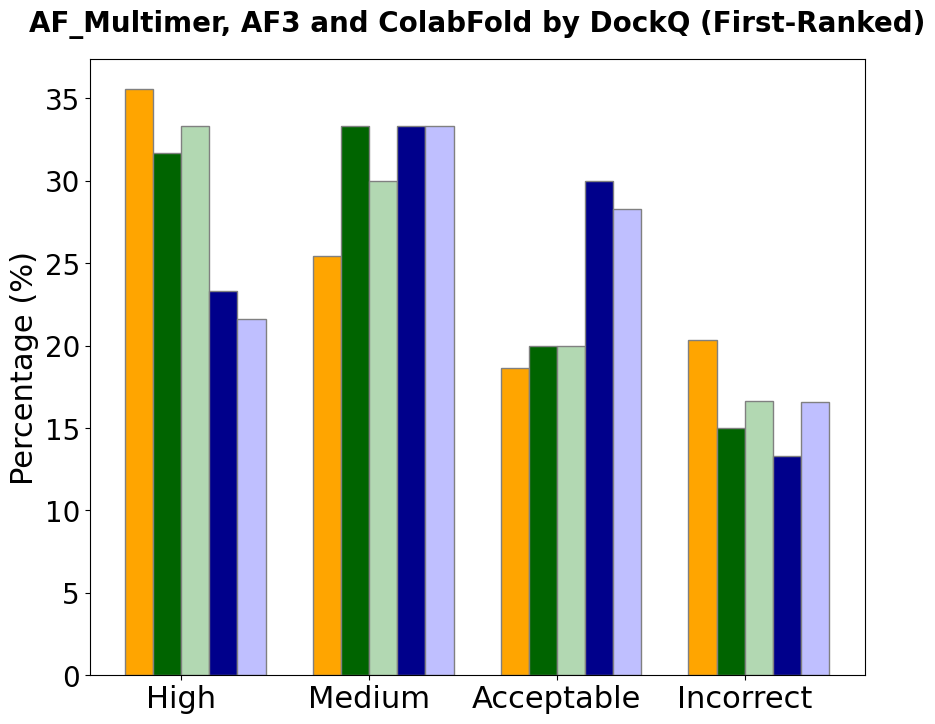

In [18]:
import matplotlib.pyplot as plt
import numpy as np

figures_directory = config["Main_Figures_directory"]

# Data for the first-ranked TB and TF of AlphaFold_Multimer and ColabFold
categories = ['High', 'Medium', 'Acceptable', 'Incorrect']
# AlphaFold values
af3_values = [35.59, 25.42, 18.64, 20.33]
af_tb_values = [31.66, 33.33, 20.00, 15.00]
af_tf_values = [33.33, 30.00, 20.00, 16.66]
# ColabFold values
cf_tb_values = [23.33, 33.3, 30.0, 13.3]
cf_tf_values = [21.6, 33.3, 28.3, 16.6]

# Positions of the bar-groups
barWidth = 0.15  # Narrower bar width to fit all bars
r1 = np.arange(len(categories))  # Positions for the first set of bars
r2 = [x + barWidth for x in r1]  # Positions for the second set
r3 = [x + barWidth for x in r2]  # Positions for the third set
r4 = [x + barWidth for x in r3]  # Positions for the fourth set
r5 = [x + barWidth for x in r4]  # Positions for the fourth set

# Create the plot with adjusted figure size
plt.figure(figsize=(10, 8))  # Slightly wider figure to accommodate more bars
plt.bar(r1, af3_values, color='orange', width=barWidth, edgecolor='grey', label='AlphaFold3')
plt.bar(r2, af_tb_values, color='#006400', width=barWidth, edgecolor='grey', label='AlphaFold Template_based')
plt.bar(r3, af_tf_values, color='#b2d8b2', width=barWidth, edgecolor='grey', label='AlphaFold Template_Free')
plt.bar(r4, cf_tb_values, color='darkblue', width=barWidth, edgecolor='grey', label='ColabFold Template_based')
plt.bar(r5, cf_tf_values, color='#bfbfff', width=barWidth, edgecolor='grey', label='ColabFold Template_Free')

# Add xticks on the middle of the group bars, adjust font sizes
plt.xticks([r + 1.5*barWidth for r in range(len(categories))], categories, rotation=0, fontsize=22)
#plt.xlabel('Quality Category', fontsize=18)  # Larger font size for x-axis label
plt.ylabel('Percentage (%)', fontsize=22)  # Larger font size for y-axis label

# Adjust y-axis font size
plt.tick_params(axis='y', labelsize=20)  # Adjusted y-axis font size

# Create legend & Show graphic with larger font
#plt.legend(fontsize=14)
plt.title('AF_Multimer, AF3 and ColabFold by DockQ (First-Ranked)', fontsize=20, fontweight='bold', pad=20)  # Added pad parameter

# Construct the output path
output_filename = 'Fig_1b.png'
output_path = f"{figures_directory}/{output_filename}"

plt.savefig(output_path, format='png', dpi=1000)

plt.show()

